## AI28 - Projet - Prédiction du niveau de revenus.

In [49]:
# OS
import sys


# WARNINGS
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('error', category=DeprecationWarning)

# NUMPY
import numpy as np

# STATS
import scipy.stats as stats
from scipy.stats import norm, skew

# MATPLOTLIB
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight') 

params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (10, 8)}
plt.rcParams.update(params)


# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 

# SEABORN 
import seaborn as sns
# sns.set_context("poster")
# sns.set_style("ticks")

# SCHIKIT-LEARN: PRE-PROCESSING
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # Encodage des variables catégorielles ordinales
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder # Encodage des variables catégorielles nominales
from sklearn.preprocessing import StandardScaler # Standardisation des variables numériques
from sklearn.preprocessing import MinMaxScaler # Normalisation MinMax
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer # Imputation
from sklearn.impute import KNNImputer 


# SCHIKIT-LEARN: MODELES
from sklearn import linear_model # Classe Modèle linéaire 
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso 
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR 
from sklearn.neighbors import KNeighborsClassifier

# SCHIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score # Validation croisée pour comparaison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation: visualiser les scores lors du choix d'un hyperparamétre
from sklearn.model_selection import GridSearchCV # Tester plusieurs hyperparamètres
from sklearn.model_selection import RandomizedSearchCV # Tester plusieurs hyperparamètres
from sklearn.model_selection import learning_curve # Courbe d'apprentissage: visualisation des scores du train et du validation sets en fonction des quantités des données
import optuna
from optuna.trial import FixedTrial
 
## EVALUATION

from sklearn.metrics import r2_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error #  MAE
from sklearn.metrics import mean_squared_error  # RMSE
from sklearn.metrics import median_absolute_error # Erreur de la médiane absolue

# SCHIKIT-LEARN: PIPELINE AND TRANSFORMATEUR
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# SOURCE DATA
from ucimlrepo import fetch_ucirepo 

In [50]:
# Utilisation des commandes fournies par UCI

# Télécharger le jeu de données 
data_adult = fetch_ucirepo(id=2) 

In [51]:
# data (as pandas dataframes) 
x = data_adult.data.features # variables explicatives
y = data_adult.data.targets # variables cibles

In [52]:
# metadata 
print(data_adult.metadata) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [53]:
# variable information 
print(data_adult.variables) 

              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

## Analyse exploratoire des données

Pour réaliser l'AED, nous utilisons les données des fichiers téléchargés depuis le site web.

In [54]:
df_adult = pd.read_csv("./Data/adult.data", header=None)

In [55]:
isinstance(df_adult, pd.DataFrame)

True

Le fichier ne contient pas les noms des colonnes. Nous les ajoutons dans le dataframe adult.

In [56]:
adult_columns = data_adult.variables['name']

df_adult.columns = adult_columns

df_adult.head()

name,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [57]:
df_adult.shape

(32561, 15)

In [58]:
df_adult.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object', name='name')

In [59]:
df_adult.describe()

name,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [60]:
df_adult.isna().sum()

name
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [61]:
df_adult = df_adult.drop_duplicates()
df_adult[df_adult.duplicated()]

name,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


In [62]:
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32537 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32537 non-null  int64 
 1   workclass       32537 non-null  object
 2   fnlwgt          32537 non-null  int64 
 3   education       32537 non-null  object
 4   education-num   32537 non-null  int64 
 5   marital-status  32537 non-null  object
 6   occupation      32537 non-null  object
 7   relationship    32537 non-null  object
 8   race            32537 non-null  object
 9   sex             32537 non-null  object
 10  capital-gain    32537 non-null  int64 
 11  capital-loss    32537 non-null  int64 
 12  hours-per-week  32537 non-null  int64 
 13  native-country  32537 non-null  object
 14  income          32537 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


Problème : La description des données indique qu'elles contiennent des valeurs inconnues. Ces valeurs ne sont pas en NaN ou null. Nous pouvons déjà remarquer la présence de '?' en leur lieu et place.

## Traitement des données

### Analyse des traitements à réaliser

Nombre de valeurs manquantes : name
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     582
income               0
dtype: int64


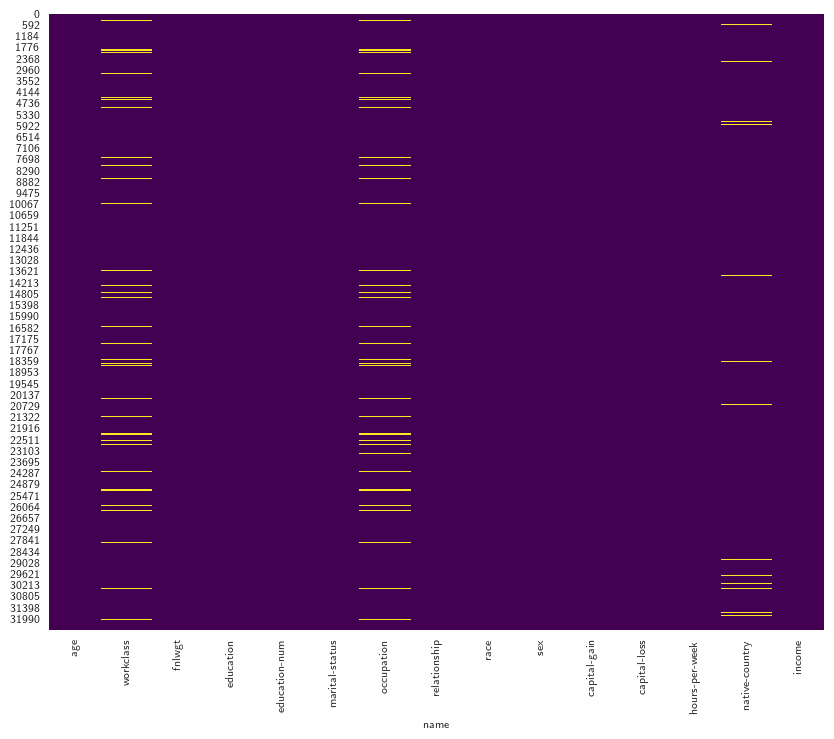

In [63]:
df_adult = df_adult.replace('\?', np.nan, regex=True)
sns.heatmap(df_adult.isna(), cbar=False, cmap='viridis')
print(f"Nombre de valeurs manquantes : {df_adult.isna().sum()}")

In [64]:
wrkclass_proportion = df_adult["workclass"].value_counts(dropna=False) / df_adult.shape[0]
print("workclass : ", wrkclass_proportion.idxmax(), f"{wrkclass_proportion.max() * 100:.2f}% ({len(wrkclass_proportion)} valeurs uniques)")
occupation_proportion = df_adult["occupation"].value_counts(dropna=False) / df_adult.shape[0]
print("occupation : ", occupation_proportion.idxmax(), f"{occupation_proportion.max() * 100:.2f}% ({len(occupation_proportion)} valeurs uniques)")
native_country_proportion = df_adult["native-country"].value_counts(dropna=False) / df_adult.shape[0]
print("native_country : ", native_country_proportion.idxmax(), f"{native_country_proportion.max() * 100:.2f}% ({len(native_country_proportion)} valeurs uniques)")
income_proportion = df_adult["income"].value_counts(dropna=False) / df_adult.shape[0]
print("income : ", income_proportion.idxmax(), f"{income_proportion.max() * 100:.2f}% ({len(income_proportion)} valeurs uniques)")

workclass :   Private 69.68% (9 valeurs uniques)
occupation :   Prof-specialty 12.71% (15 valeurs uniques)
native_country :   United-States 89.60% (42 valeurs uniques)
income :   <=50K 75.91% (2 valeurs uniques)


 ### Creation de la fonction de traitement des données

In [135]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def treat_df(df, preprocessor = None):
    df_new = df.copy()
    # Remplacement de la valeur '?' par NaN
    df_new = df_new.replace('\?', np.nan, regex=True)
    # Remplacement des valeurs manquantes par les valeurs les plus fréquentes, les seules variables concernées sont workclass, occupation et native-country
    for col in ["workclass", "occupation", "native-country"]:
        df_new[col].fillna(df_new[col].mode()[0], inplace=True)

    # Selection des different types de variables
    categorical_columns = df_new.select_dtypes(include=['object']).columns
    numerical_columns = df_new.select_dtypes(include=['number']).columns
    # Retrait de la variable cible des colonnes categorielles à traiter
    categorical_columns = categorical_columns.drop('income')

    # Pretraitement des features
    if preprocessor is None:
        preprocessor = ColumnTransformer(
            transformers = [
                ('numerical', StandardScaler(), numerical_columns),
                # Aucune feature n'est ordonnée ou a besoin d'ordre (en réalité on pourrait debattre de cela pour la variable education)
                ('categorical', OneHotEncoder(sparse_output=False), categorical_columns)
            ]
        )
        preprocessor.fit(df_new.drop("income", axis=1))
    features_processed = preprocessor.transform(df_new.drop('income', axis=1))
    column_names = (
        preprocessor.named_transformers_['numerical'].get_feature_names_out(numerical_columns).tolist() +
        preprocessor.named_transformers_['categorical'].get_feature_names_out(categorical_columns).tolist()
    )
    df_processed = pd.DataFrame(features_processed, columns=column_names)
    # Pretraitement de la variable cible, (0: <=50K, 1: >50K)
    label_encoder = LabelEncoder()
    df_processed['income'] = label_encoder.fit_transform(df_new['income'])
    print(df_new['income'].value_counts())
    print(df_processed['income'].value_counts())
    return df_processed, preprocessor

## Modele de prediction

### Préparation des modèles

Nous comptons utiliser la librairie `optuna` pour l'optimisation des hyperparamètres. Afin de permettre une comparaison facile des modèles entre eux, nous préparons des fonctions pour chaque modèle que nous souhaitons optimiser.

In [147]:
from sklearn.metrics import confusion_matrix

# Creation de différents sets
# X_train, X_test, y_train, y_test = train_test_split(df_adult_enco.drop(columns=["income"]), df_adult_enco["income"], test_size=0.2, random_state=69)
#
# # On normalise les variables quantitatives sur les données de train (StandardScaler pour l'instant)
# numerical_columns = df_adult.select_dtypes(include=['int64', 'float64']).columns
# numerical_scaler = StandardScaler()
# numerical_scaler.fit(X_train[numerical_columns])
# X_train[numerical_columns] = numerical_scaler.transform(X_train[numerical_columns])
# X_test[numerical_columns] = numerical_scaler.transform(X_test[numerical_columns])

# Import des données de test
df_adult_test = pd.read_csv("./Data/adult.test", header=None)
df_adult_test.columns = adult_columns

# Creation de différents sets (repartition 66/33 pour train/test)
df_adult_new, fitted_preprocessor = treat_df(df_adult, None)
X_train, y_train = df_adult_new.drop(columns=["income"]), df_adult_new["income"]
df_adult_test_new, _ = treat_df(df_adult_test, fitted_preprocessor)
X_test, y_test = df_adult_test_new.drop(columns=["income"]), df_adult_test_new["income"]

def eval_model(model, X_test, y_test):
    """
    :return: accuracy, recall, neg_recall, f1, r2, mae, rmse, accuracy_neg_pred, accuracy_pos_pred
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    neg_recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    print(f"Accuracy : {accuracy:.4f} (the higher the better)")
    print(f"Recall : {recall:.4f} (the higher the better) (best for us)")
    print(f"Negative recall : {neg_recall:.4f} (the lower the better)")
    print(f"F1 : {f1:.4f} (the higher the better)")
    print(f"R2 : {r2:.4f} (the higher the better)")
    print(f"MAE : {mae:.4f} (the lower the better)")
    print(f"RMSE : {rmse:.4f} (the lower the better)")
    return accuracy, recall, neg_recall, f1, r2, mae, rmse

income
<=50K    24698
>50K      7839
Name: count, dtype: int64
income
0    24698
1     7839
Name: count, dtype: int64
income
<=50K    12435
>50K      3846
Name: count, dtype: int64
income
0    12435
1     3846
Name: count, dtype: int64


### Arbre de décision

In [67]:
from sklearn.tree import DecisionTreeClassifier

def opt_decision_tree(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    return DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion
    )

### Random forest

In [68]:
from sklearn.ensemble import RandomForestClassifier

def opt_random_forest(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 10)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 4)
    rf_max_features = trial.suggest_categorical('rf_max_features', ['sqrt', 'log2'])
    rf_criterion = trial.suggest_categorical('rf_criterion', ['gini', 'entropy'])
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)
    return RandomForestClassifier(
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf,
        max_features=rf_max_features,
        criterion=rf_criterion,
        n_estimators=rf_n_estimators
    )

### Regression logistique

In [69]:
from sklearn.linear_model import LogisticRegression

def opt_logistic_regression(trial):
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])

    # Filter penalties based on the solver
    penalty = "l2"  # Default penalty if an error occurs
    if solver in ['newton-cg', 'lbfgs', 'sag']:
        penalty = trial.suggest_categorical('penalty', ['l2', None])
    elif solver == 'liblinear':
        penalty = trial.suggest_categorical('penalty-liblinear', ['l1', 'l2'])
    elif solver == 'saga':
        penalty = trial.suggest_categorical('penalty-saga', ['l1', 'l2', 'elasticnet', None])
    # l1_ratio est utlisé pour l'elasticnet
    l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.5, log=True)
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    max_iter = trial.suggest_int('max_iter', 50, 500)
    return LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        max_iter=max_iter,
        l1_ratio=l1_ratio,
    )

### AdaBoosting

In [70]:
from sklearn.ensemble import AdaBoostClassifier

def opt_adaboost(trial):
    base_estimator = trial.suggest_categorical('base_estimator', ['DecisionTree', 'RandomForest'])
    base_estimator_obj = None
    if base_estimator == 'DecisionTree':
        base_estimator_obj = opt_decision_tree(trial)
    elif base_estimator == 'RandomForest':
        base_estimator_obj = opt_random_forest(trial)

    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)

    return AdaBoostClassifier(
        estimator=base_estimator_obj,
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )

### Gradient boosting

In [71]:
from xgboost import XGBClassifier

def opt_gradient_boosting(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    return XGBClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )

### Stacking

In [72]:
from sklearn.ensemble import StackingClassifier

def opt_stacking(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 10)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 4)
    rf_max_features = trial.suggest_categorical('rf_max_features', ['sqrt', 'log2'])
    rf_criterion = trial.suggest_categorical('rf_criterion', ['gini', 'entropy'])
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)

    xgb_max_depth = trial.suggest_int('xgb_max_depth', 2, 32)
    xgb_min_samples_split = trial.suggest_int('xgb_min_samples_split', 2, 10)
    xgb_min_samples_leaf = trial.suggest_int('xgb_min_samples_leaf', 1, 4)
    xgb_max_features = trial.suggest_categorical('xgb_max_features', ['sqrt', 'log2'])
    xgb_criterion = trial.suggest_categorical('xgb_criterion', ['gini', 'entropy'])
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 200)

    return StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(
                max_depth=rf_max_depth,
                min_samples_split=rf_min_samples_split,
                min_samples_leaf=rf_min_samples_leaf,
                max_features=rf_max_features,
                criterion=rf_criterion,
                n_estimators=rf_n_estimators
            )),
            ('xgb', XGBClassifier(
                max_depth=xgb_max_depth,
                min_samples_split=xgb_min_samples_split,
                min_samples_leaf=xgb_min_samples_leaf,
                max_features=xgb_max_features,
                criterion=xgb_criterion,
                n_estimators=xgb_n_estimators
            ))
        ],
        final_estimator=XGBClassifier(random_state=69)
    )

## KNN (K-Nearest Neighbors)

In [73]:
def opt_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 10, 50)
    p = trial.suggest_int('p', 1, 2)

    return make_pipeline(
        StandardScaler(),  # très important pour KNN
        KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            algorithm=algorithm,
            leaf_size=leaf_size,
            p=p
        )
    )

## Classification de Bayes

In [74]:
from sklearn.naive_bayes import GaussianNB

def opt_bayes(trial):
    var_smoothing = trial.suggest_float('var_smoothing', 1e-11, 1e-6, log=True)
    return GaussianNB(var_smoothing=var_smoothing)

### Machine à vecteurs de support (SVM)

In [75]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

def opt_svm(trial):
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3  # Seulement pour le kernel poly
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    # On wrap autour du BaggingClassifier pour accelerer l'entrainement et améliorer le modèle
    return BaggingClassifier(SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        degree=degree,
        class_weight=class_weight,
        probability=True  # Active les estimations en probabilités pour le courbe ROC
    ), n_estimators=n_estimators, max_samples=1.0 / n_estimators)

### KMeans

In [76]:
from sklearn.cluster import KMeans

def opt_kmeans(trial):
    # n_clusters = trial.suggest_int('n_clusters', 2, 20)
    init = trial.suggest_categorical('init', ['k-means++', 'random'])
    n_init = trial.suggest_int('n_init', 10, 50)
    max_iter = trial.suggest_int('max_iter', 100, 500)
    tol = trial.suggest_float('tol', 1e-6, 1e-2, log=True)
    return KMeans(
        n_clusters=2,
        init=init,
        n_init=n_init,
        max_iter=max_iter,
        tol=tol,
    )

### HDBScan

In [77]:
from sklearn.cluster import HDBSCAN

def opt_hdbscan(trial):
    min_cluster_size = trial.suggest_int('min_cluster_size', 2, 50)
    min_samples = trial.suggest_int('min_samples', 1, 10)
    cluster_selection_epsilon = trial.suggest_float('cluster_selection_epsilon', 0.0, 0.5)
    return HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=cluster_selection_epsilon
    )

## Optimisation des hyperparamètres pour differents classifieurs avec `optuna`

On optimise les differents hyperparamètres pour chaque classifieur et on stocke le meilleur modele de chaque classifieur dans un dictionnaire pour les évaluer et comparer ensuite.

In [138]:
def get_objective_func(opt_func):
    def objective(trial):
        model = opt_func(trial)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        recall = recall_score(y_test, y_pred)
        return recall
    return objective


best_models = {}

def get_best_model_for_classifier(name, opt_func):
    study = optuna.create_study(direction='maximize', study_name=f"{name} - Adult Income Prediction")
    study.optimize(get_objective_func(opt_func), n_trials=150, timeout=900)
    print(f"{name} Best hyperparameters: ", study.best_params)
    return opt_func(FixedTrial(study.best_params))

# DecisionTree
best_models["DecisionTree"] = get_best_model_for_classifier("DecisionTree", opt_decision_tree)
# RandomForest
# best_models["RandomForest"] = get_best_model_for_classifier("RandomForest", opt_random_forest)
# LogisticRegression
# best_models["LogisticRegression"] = get_best_model_for_classifier("LogisticRegression", opt_logistic_regression)
# AdaBoosting
# best_models["AdaBoosting"] = get_best_model_for_classifier("AdaBoosting", opt_adaboost)
# XGBoosting
best_models["XGBoosting"] = get_best_model_for_classifier("XGBoosting", opt_gradient_boosting)
# Stacking
# best_models["Stacking"] = get_best_model_for_classifier("Stacking", opt_stacking)
# KNN
# best_models["KNN"] = get_best_model_for_classifier("KNN", opt_knn)
# NaiveBayes
# best_models["NaiveBayes"] = get_best_model_for_classifier("NaiveBayes", opt_bayes)
# SVM
# best_models["SVM"] = get_best_model_for_classifier("SVM", opt_svm)
# KMean
# best_models["KMeans"] = get_best_model_for_classifier("KMeans", opt_kmeans)
# HDBSCAN - Ne marche pas pour nous
# best_models["HDBSCAN"] = get_best_model_for_classifier("HDBSCAN", opt_hdbscan)


[I 2025-06-18 18:01:28,135] A new study created in memory with name: DecisionTree - Adult Income Prediction
[I 2025-06-18 18:01:28,293] Trial 0 finished with value: 0.5678627145085804 and parameters: {'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.5678627145085804.
[I 2025-06-18 18:01:28,331] Trial 1 finished with value: 0.36011440457618304 and parameters: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.5678627145085804.
[I 2025-06-18 18:01:28,387] Trial 2 finished with value: 0.500780031201248 and parameters: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 0 with value: 0.5678627145085804.
[I 2025-06-18 18:01:28,447] Trial 3 finished with value: 0.4040561622464899 and parameters: {'max_depth': 7, 'min_samples_split': 10, 'mi

DecisionTree Best hyperparameters:  {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'entropy'}


[I 2025-06-18 18:01:52,134] Trial 0 finished with value: 0.6495059802392096 and parameters: {'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'gini', 'n_estimators': 97, 'learning_rate': 0.2792122038903228}. Best is trial 0 with value: 0.6495059802392096.
[I 2025-06-18 18:02:05,591] Trial 1 finished with value: 0.6294851794071763 and parameters: {'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'criterion': 'gini', 'n_estimators': 182, 'learning_rate': 0.05437085114172321}. Best is trial 0 with value: 0.6495059802392096.
[I 2025-06-18 18:02:06,860] Trial 2 finished with value: 0.6479459178367135 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'entropy', 'n_estimators': 112, 'learning_rate': 0.2904983946424905}. Best is trial 0 with value: 0.6495059802392096.
[I 2025-06-18 18:02:07,629] Trial 3 finished with value: 0.591263650546

XGBoosting Best hyperparameters:  {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'criterion': 'entropy', 'n_estimators': 130, 'learning_rate': 0.2919788418265516}


## Evaluation et comparaison des modèles


In [148]:
# On mélange les données utilisées pour le test et le train et un dataframe pour éviter un biais du à l'overfitting
df_adult_new = pd.concat([df_adult_new, df_adult_test_new])

# On prend de nouvelles données pour éviter un biais du à l'overfitting
X_train, X_test, y_train, y_test = train_test_split(df_adult_new.drop(columns=["income"]), df_adult_new["income"], test_size=0.2, random_state=69)
# On normalise les variables quantitatives sur les données de train (StandardScaler pour l'instant)

df_models_res = pd.DataFrame(columns=["name", "accuracy", "recall", "negative recall", "f1", "r2", "mae", "rmse"])

for classifier_name, model in best_models.items():
    model.fit(X_train, y_train)
    print(f"\n=== Evaluation du meilleur modèle du classifieur {classifier_name} ===")
    df_models_res.loc[len(df_models_res)] =(classifier_name,) + eval_model(model, X_test, y_test)

df_models_res.style


=== Evaluation du meilleur modèle du classifieur DecisionTree ===
Accuracy : 0.8309 (the higher the better)
Recall : 0.5890 (the higher the better) (best for us)
Negative recall : 0.9085 (the lower the better)
F1 : 0.6286 (the higher the better)
R2 : 0.0806 (the higher the better)
MAE : 0.1691 (the lower the better)
RMSE : 0.1691 (the lower the better)

=== Evaluation du meilleur modèle du classifieur XGBoosting ===
Accuracy : 0.8724 (the higher the better)
Recall : 0.6497 (the higher the better) (best for us)
Negative recall : 0.9439 (the lower the better)
F1 : 0.7121 (the higher the better)
R2 : 0.3061 (the higher the better)
MAE : 0.1276 (the lower the better)
RMSE : 0.1276 (the lower the better)


,name,accuracy,recall,negative recall,f1,r2,mae,rmse
0,DecisionTree,0.830909,0.588954,0.908550,0.628571,0.080613,0.169091,0.169091
1,XGBoosting,0.872388,0.649663,0.943858,0.712107,0.306144,0.127612,0.127612


### Courbe ROC

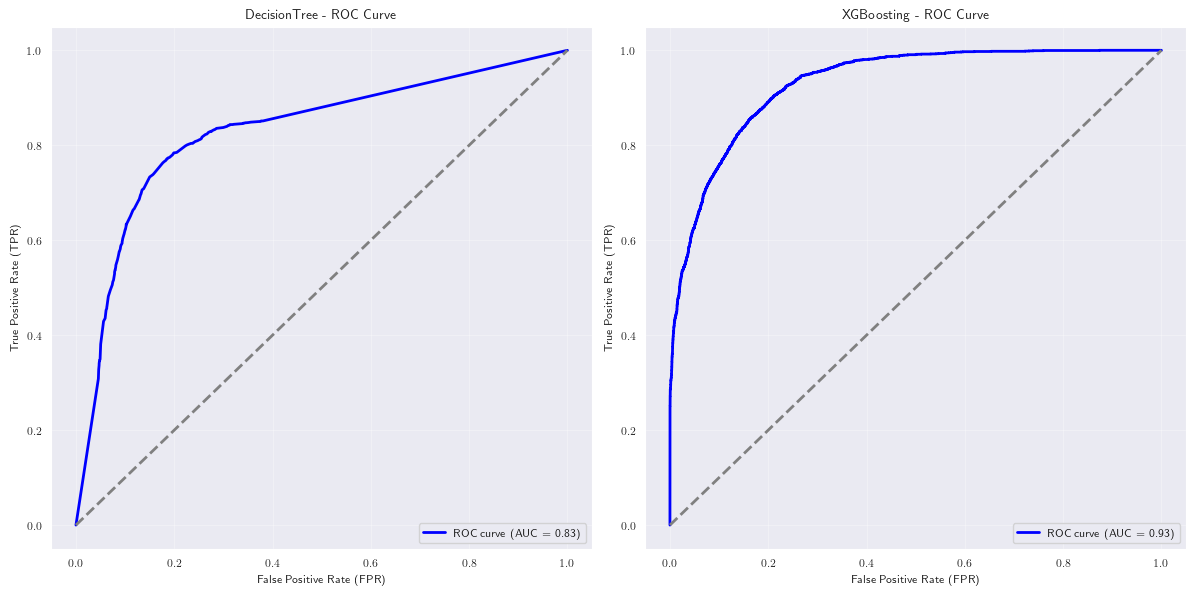

In [150]:
from math import ceil
from sklearn.metrics import roc_curve, auc

# Number of models
num_models = len(best_models)
rows = ceil(num_models / 2)  # Calculate the number of rows needed

plt.figure(figsize=(12, 6 * rows))

for i, (classifier_name, model) in enumerate(best_models.items(), start=1):
    # Modele de clustering
    if classifier_name == "KMeans":
        continue
    # Prédictions des probabilités pour la classe positive
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # Calcul des FPR, TPR et seuils
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    # Calcul de l'AUC
    roc_auc = auc(fpr, tpr)
    # Subplot for each ROC curve
    plt.subplot(rows, 2, i)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Ligne diagonale
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{classifier_name} - ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Courbe de précision-rappel

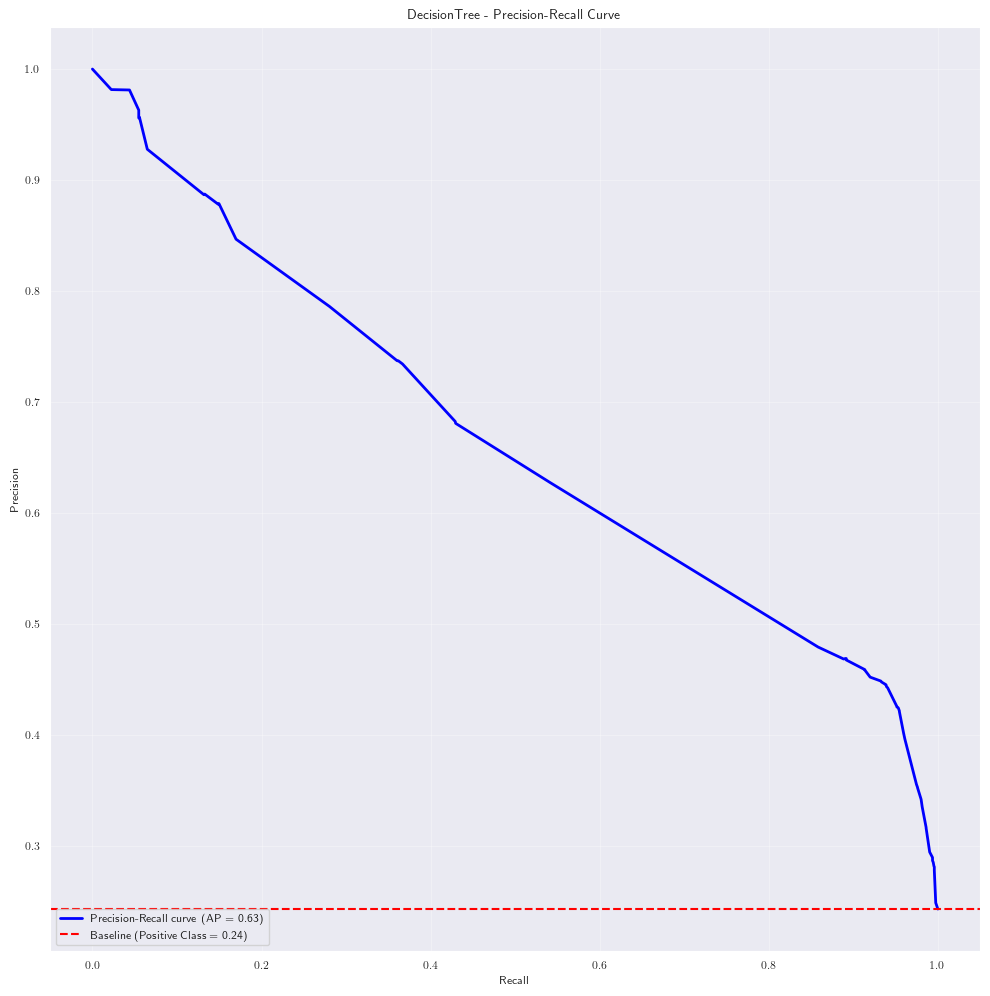

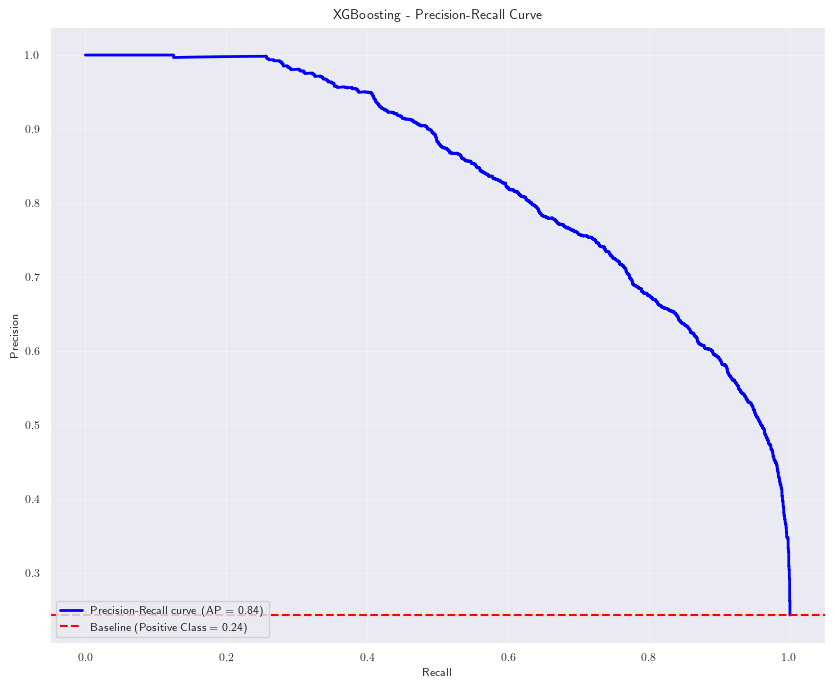

<Figure size 1000x800 with 0 Axes>

In [43]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Number of models
num_models = len(best_models)
rows = ceil(num_models / 2)  # Calculate the number of rows needed

plt.figure(figsize=(12, 6 * rows))

for i, (classifier_name, model) in enumerate(best_models.items(), start=1):
    if classifier_name == "KMeans":
        continue
    # Prédictions des probabilités pour la classe positive
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # Calcul de la precision du rappel, et des seuils
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    # Calcul de la moyenne de précision
    avg_precision = average_precision_score(y_test, y_pred_proba)
    # Calcul de la proportion de la classe positive dans les données de test
    positive_class_proportion = y_test.mean()
    # Calcul de l'AUC pour la courbe de précision-rappel
    pr_auc = auc(recall, precision)
    # Tracé de la courbe de précision-rappel
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    # Tracé de la baseline pour la classe positive
    plt.axhline(y=positive_class_proportion, color='red', linestyle='--', label=f'Baseline (Positive Class = {positive_class_proportion:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{classifier_name} - Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(alpha=0.3)
    plt.show()

plt.tight_layout()
plt.show()

### Visualisation des modèles de clustering

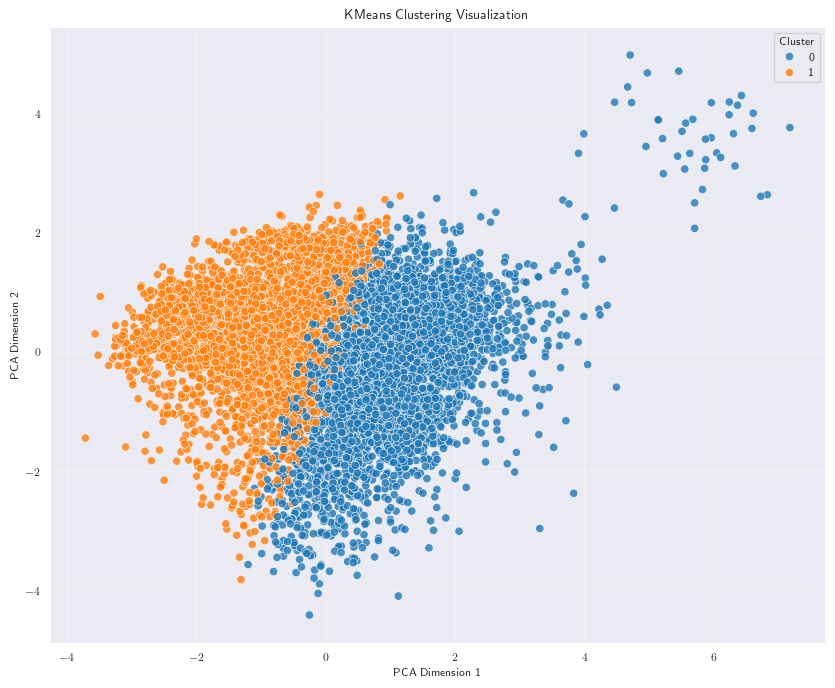

In [41]:
kmeans = best_models["KMeans"]
from sklearn.decomposition import PCA

# Reduce dimensions using PCA
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test)

# Predict cluster labels
kmeans = best_models["KMeans"]
clusters = kmeans.predict(X_test)

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_test_2d[:, 0],
    y=X_test_2d[:, 1],
    hue=clusters,
    alpha=0.8,
    legend='full'
)
plt.title('KMeans Clustering Visualization')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend(title='Cluster')
plt.grid(alpha=0.3)
plt.show()

## Visualisation UMAP

In [34]:
# import umap.umap_ as umap
#
# # UMAP reduction
# reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
# embedding_2d = reducer.fit_transform(X_test)
#
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(
#     embedding_2d[:, 0], embedding_2d[:, 1],
#     c=y_test, cmap='Spectral', s=10, alpha=0.7
# )
# plt.colorbar(scatter, label='Digit Label')
# plt.title('UMAP Projection of Model Embeddings')
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')
# plt.grid(True)
# plt.show()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
27495,0.030949,-0.978937,-2.746699,-0.145623,-0.218008,-0.029810,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20439,-1.067053,-0.013400,-1.195226,-0.145623,-0.218008,-0.029810,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4726,-0.554652,0.671663,-0.031621,-0.145623,3.673221,0.375673,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28590,-0.408252,1.497441,-0.419489,-0.145623,-0.218008,-0.029810,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,

<Axes: >

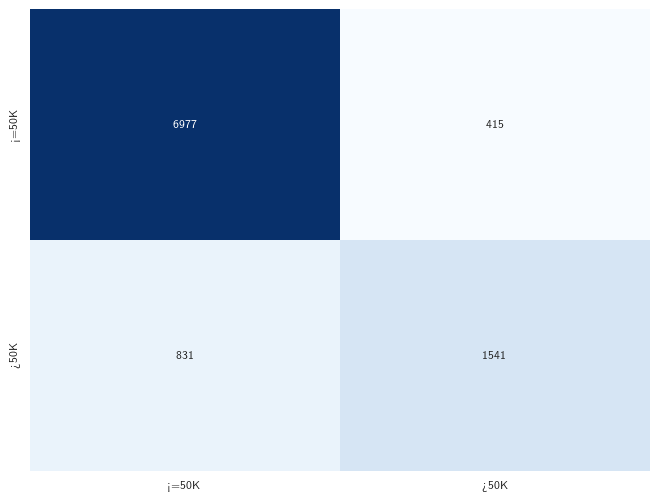

In [149]:
cm = confusion_matrix(y_test, best_models["XGBoosting"].predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])